# Federated Learning Simple Implementation

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import numpy as np
from tqdm import tqdm
import seaborn as sns
from fedlern.utils import *
from fedlern.train_utils import *
from fedlern.quant_utils import *
from fedlern.models.resnet_v2 import ResNet18

## Relevant Parameters

In [39]:
epoch = 10
rounds = 30
num_clients = 10

clients_sample_size = int(.3 * num_clients) # Use 30% of available clients
num_workers = 8
train_batch_size =128
eval_batch_size=256
quantize_bits = 4
stats = (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)

## Data Loaders
- Divide the test & training data
- Divide the training data among the clients

In [40]:
 # Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test)

# split the training data
train_splits = torch.utils.data.random_split(train_dataset, [int(train_dataset.data.shape[0]/num_clients) for i in range(num_clients)])

# Data loaders
train_loaders = [DataLoader(dataset=split, batch_size=train_batch_size, shuffle=True, num_workers=num_workers) for split in train_splits]
test_loader = DataLoader(dataset=test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Files already downloaded and verified


## Helper Functions for Federated Training
- `client_update` function train the client model on private client data. This is the local training round that takes place at num_selected clients.
- `server_aggregate` function aggregates the model weights received from every client and updates the global model with the updated weights.

In [41]:

def server_aggregate(global_model : torch.nn.Module, client_models):
    """
    The means of the weights of the client models are aggregated to the global model
    """
    global_dict = global_model.state_dict() # Get a copy of the global model state_dict
    for key in global_dict.keys():
        global_dict[key] = torch.stack([client_models[i].state_dict()[key].float() for i in range(len(client_models))],0).mean(0)
    global_model.load_state_dict(global_dict)
    
    # Update the client models using the global model
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

## Global & Clients instatiation
Implement the same elements as before, but:
- We need more instances of the model
- An optimizer for each model

In [42]:
global_model = ResNet18().to(device)
client_models = [ResNet18()
                     .to(device)
                     #.load_state_dict(global_model.state_dict())
                  for _ in range(num_clients)]



# criterion = nn.CrossEntropyLoss() # computes the cross-entropy loss between the predicted and true labels
# optimizers =[optim.Adam(model.parameters(), lr=0.001) for model in client_models]


In [43]:
# Optimizer & criterion based on gobal model
global_optimizer = get_model_optimizer(global_model,
                                       learning_rate=0.1,
                                       weight_decay=5e-4)

#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80,120,160], gamma=0.1)
criterion = nn.CrossEntropyLoss().to(device) # computes the cross-entropy loss between the predicted and true labels

optimizers = [get_model_optimizer(model,learning_rate=0.1, weight_decay=5e-4) for model in client_models]

In [44]:
# initialize lists to store the training and testing losses and accuracies
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for round in tqdm(range(rounds)):


    # Select n random clients
    selected_clients = np.random.permutation(num_clients)[:clients_sample_size]
    # Train the selected clients
    for client in selected_clients:
        # Individual criterion and optimizer

        train_loss, train_acc = qtrain_model(model = client_models[client],
                                             train_loader = train_loaders[client],
                                             device = device,
                                             criterion = criterion,
                                             optimizer = optimizers[client],
                                             num_epochs=epoch,
                                             bits = quantize_bits)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Aggregate
    server_aggregate(global_model, client_models)

    # Test the global model
    test_loss, test_acc = evaluate_model(model=global_model,
                                         test_loader=test_loader,
                                         device=device,
                                         criterion=criterion)

    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"{round}-th ROUND: average train loss {(train_loss / clients_sample_size):0.3g} | test loss {test_loss:0.3g} | test acc: {test_acc:0.3f}")
    
    

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0/5 Train Loss: 3.268 Train Acc: 0.134
Epoch: 1/5 Train Loss: 2.178 Train Acc: 0.201
Epoch: 2/5 Train Loss: 2.011 Train Acc: 0.252
Epoch: 3/5 Train Loss: 1.962 Train Acc: 0.269
Epoch: 4/5 Train Loss: 1.960 Train Acc: 0.271
Epoch: 0/5 Train Loss: 3.115 Train Acc: 0.154


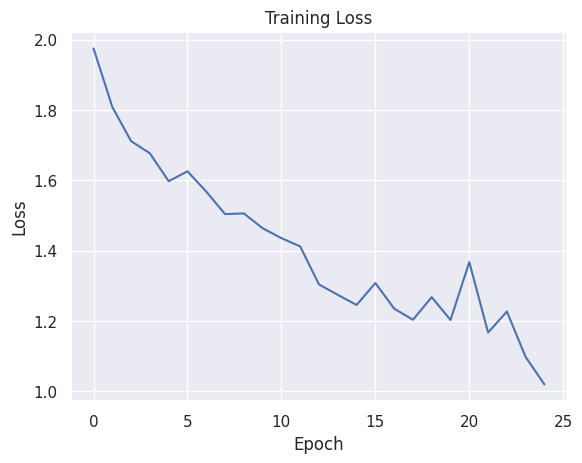

In [ ]:
# plot the training loss
sns.set(style='darkgrid')
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
train_accs = [d.item() for d in train_accs]
test_accs = [d.item() for d in test_accs]

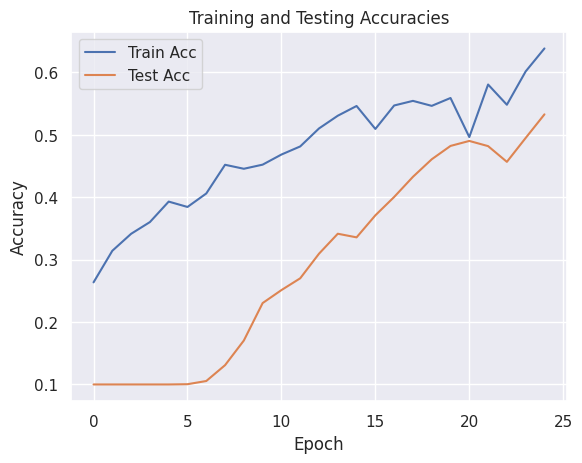

In [ ]:
# plot the training and testing accuracies
sns.set(style='darkgrid')
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")
# Test the model
loss, acc = evaluate_model(global_model, test_loader, device,)
print(f'Loss: {loss}, Accuracy: {acc*100}%')
print_model_size(global_model)

# Measure inference latency
cpu_inference_latency = measure_inference_latency(model=global_model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
gpu_inference_latency = measure_inference_latency(model=global_model, device=cuda_device, input_size=(1,3,32,32), num_samples=100)
print("CPU Inference Latency: {:.2f} ms / sample".format(cpu_inference_latency * 1000))
print("CUDA Inference Latency: {:.2f} ms / sample".format(gpu_inference_latency * 1000))

Loss: 0.0, Accuracy: 53.27999496459961%
44.77 MB
CPU Inference Latency: 7.29 ms / sample
CUDA Inference Latency: 7.48 ms / sample


In [ ]:
save_model(global_model, "saved_models", f'resnet_fedlern_{quantize_bits}bits_{time_stamp()}.pth')